# S21 simulation of a resonator

Authors: Sara Buhktari, Christian Kraglund Andersen


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

In [2]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'

# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '15 um' #S from reference 2
design.variables['cpw_gap'] = '9 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [4]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

In [5]:
# Single feedline
x = '-1.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

x = '1.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)


TL_LP1_LP2 = RoutePathfinder(design, 'TL_LP1_LP2', options = dict(chip='main', trace_width ='15um',
        trace_gap ='9um',
                                            fillet='99um',
                                            lead=dict(end_straight='1.972mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


gui.rebuild()


In [6]:
# lambda/2 resonator
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', pos_x='-0.3mm',  pos_y='1.96mm', orientation='180'))
otg2 = OpenToGround(design, 'otg1e', options=dict(chip='main', pos_x='0.0mm',  pos_y='0.0mm', orientation='270'))
rt_meander = RouteMeander(design, 'meander',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='8.0mm',
        hfss_wire_bonds = False,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='otg1e', pin='open')), ))
gui.rebuild()

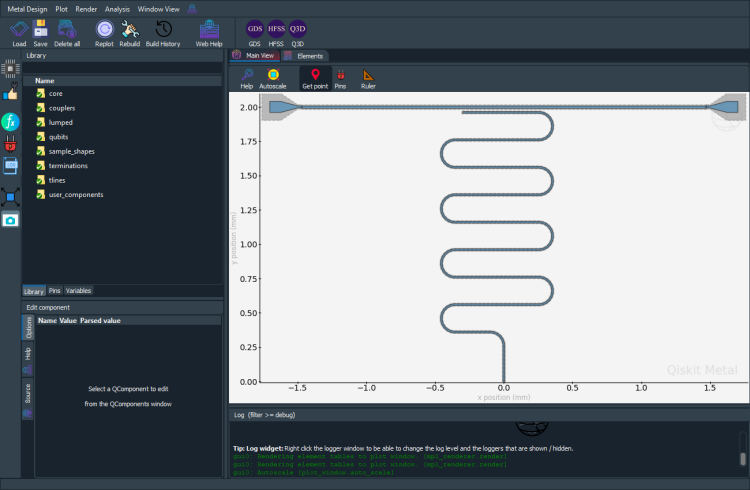

In [7]:
gui.autoscale()
gui.screenshot()

# Scattering Analysis

In [8]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [9]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [10]:
hfss = em1.renderer
hfss.start()

INFO 10:23PM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:23PM [load_ansys_project]: 	Opened Ansys App
INFO 10:23PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 10:23PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/christianander/Documents/Ansoft/
	Project:   Project4
INFO 10:23PM [connect_design]: No active design found (or error getting active design).
INFO 10:23PM [connect]: 	 Connected to project "Project4". No design detected


True

In [11]:
hfss.activate_ansys_design("HangingResonators", 'drivenmodal')

10:23PM 55s WARNING [activate_ansys_design]: The design_name=HangingResonators was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 10:24PM [connect_design]: 	Opened active design
	Design:    HangingResonators [Solution type: DrivenModal]
WARNING 10:24PM [connect_setup]: 	No design setup detected.
WARNING 10:24PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 10:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [12]:
hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5

In [13]:
hfss.clean_active_design()

In [14]:
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)

In [15]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=4.0,
               stop_ghz=8.0,
               count=2001,
               type="Interpolating")

INFO 10:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [16]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 10:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:24PM [analyze]: Analyzing setup Setup : Sweep


In [17]:
hfss.plot_params(['S11', 'S21'])

The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():

The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():



(                      S11                 S21
 4.000 -0.085652-0.085107j -0.710604+0.693154j
 4.002 -0.085721-0.085108j -0.710333+0.693423j
 4.004 -0.085790-0.085110j -0.710061+0.693692j
 4.006 -0.085859-0.085112j -0.709790+0.693961j
 4.008 -0.085928-0.085114j -0.709519+0.694230j
 ...                   ...                 ...
 7.992 -0.194995-0.001102j -0.040835+0.979953j
 7.994 -0.195015-0.001027j -0.040466+0.979965j
 7.996 -0.195034-0.000952j -0.040097+0.979976j
 7.998 -0.195054-0.000877j -0.039728+0.979987j
 8.000 -0.195073-0.000802j -0.039358+0.979998j
 
 [2001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [ ]:
em1.close()

In [ ]:
hfss.disconnect_ansys()

In [ ]:
gui.main_window.close()